# Heart Disease Classification

## 1. Introduction

### 1.1 Background
Cardiovascular diseases (CVDs), especially heart disorders, are a primary cause of death worldwide, according to the World Health Organization. 

The aim of this project is to answer the following question: **Is heart disease present (values = 1, 2, 3, 4) or absent (value = 0) in a new patient?**

### 1.2 Data set
To answer this question, we will analyze data downloaded from the UCI Machine Learning Repository. Below, we read the Cleveland dataset into `heart_disease_dataset`. Each row in the data set contains data about one patient. We will add a column `presence` (the predicted attribute) to indicate the presence or absence of heart disease. 

Relevant columns in the dataset:

- `age` - age in years
- `sex` - sex (1 = male; 0 = female)
- `cp` - chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- `trestbps` - resting blood pressure (in mm Hg on admission to the hospital)
- `chol` - serum cholesterol in mg/dl
- `fbs` - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- `restecg` - resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- `thalach` - maximum heart rate achieved
- `exang` - exercise induced angina (1 = yes; 0 = no)
- `oldpeak` - ST depression induced by exercise relative to rest
- `slope` - the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
- `ca` - number of major vessels (0-3) colored by flourosopy
- `thal` - 3 = normal; 6 = fixed defect; 7 = reversable defect
- `presence` - predicted attribute (1,2,3,4 - yes and 0 - no)

## 2. Methods & Results


### 2.1 Loading libraries

In [1]:
library(tidyverse)
library(dplyr)
library(tidymodels)
library(GGally)
library(ggplot2)
library(cowplot)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'tidymodels' was built under R version 3.6.3"-- Attaching packages -------------------------------------- tidymodels 0.1.2 --
v broom     0.7.6      v recipes   0.

In [17]:
set.seed(999) # reproducible

### 2.2 Reading, Cleaning, and Wrangling Data

- Assign column names `age`, `sex`, `cp`, `trestbps`, `chol`, `fbs`, `restecg`, `thalach`, `exang`, `oldpeak`, `slope`, `ca`, `thal`, `presence`.
- Filter out any rows containing NA or invalid value ("?" and negative values).
- Select only `age`, `trestbps`, `chol`, `thalach`, `oldpeak` (non-categorical variables), and `presence` (predicted attribute) columns.
- Shuffle rows of the data frame for a more representative randomly ordered data set.
- Represent `presence` as factor type.

As you will see if you cycle between the data sources, the count of no presence in the Switzerland (count = 8) and VA (count = 30) dataset was too small to be considered in the analysis. 


In [2]:
# create a data wrangling function
heart_disease_wrangler <- function(f) {
    colnames <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "presence")
    heart_disease_data <- read_csv(file, col_names = colnames, na = c("?"))

    cat("Heart disease data set from (", f, ") before dropping all NA has ", nrow(heart_disease_data), "rows and", ncol(heart_disease_data), "columns \n")

    # select only these attributes because rest are categorical variables 
    heart_disease_data <- select(heart_disease_data, age, trestbps, chol, thalach, oldpeak, presence) %>% 
        drop_na() # drop any rows with NA 

    cat("Heart disease data set after dropping all NA has ", nrow(heart_disease_data), "rows and", ncol(heart_disease_data), "columns")

    heart_disease_data <- heart_disease_data %>%
        mutate(presence = ifelse(presence == 0, "no", "yes")) %>%
        mutate(presence = as.factor(presence))

    return(heart_disease_data)
}

In [3]:
path_names <- c("data/processed.cleveland.data",
                   "data/processed.switzerland.data",
                   "data/processed.va.data")

file <- path_names[1]

heart_disease_data <- heart_disease_wrangler(file)

heart_disease_data %>%
    group_by(presence) %>%
    summarise(count = n())

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  presence = col_double()
)


Heart disease data set from ( data/processed.cleveland.data ) before dropping all NA has  303 rows and 14 columns 
Heart disease data set after dropping all NA has  303 rows and 6 columns

presence,count
no,164
yes,139


In [4]:
# Shuffling rows of the data frame so that they are no longer ordered by region and are randonly ordered
set.seed(999) # reproducible
rand_order <- sample(nrow(heart_disease_data)) # random ordering
heart_disease_data <- heart_disease_data[rand_order,] # shuffle the rows of the data frame

head(heart_disease_data) # view first few rows of data set
tail(heart_disease_data) # view last few rows of data set 

age,trestbps,chol,thalach,oldpeak,presence
51,130,305,142,1.2,yes
65,155,269,148,0.8,no
59,170,288,159,0.2,yes
63,140,195,179,0.0,no
53,140,203,155,3.1,yes
60,102,318,160,0.0,no


age,trestbps,chol,thalach,oldpeak,presence
58,128,216,131,2.2,yes
54,160,201,163,0.0,no
43,115,303,181,1.2,no
60,140,185,155,3.0,yes
63,145,233,150,2.3,no
57,165,289,124,1.0,yes


### 2.3 Splitting & Summarizing data

We will be partitioning `heart_disease_data` into a training (75%) and testing (25%) set using the `tidymodels` package. We will then find the best k-nn classifier using the training set and evaluate the performance of our model on the test dataset. We will use the variable `presence` as our class label. 

#### Summary Statistics (only using training data)
- Count the number of patients with presence = 0 (heart disease absent), and presence = 1-4 (heart disease present)
- Calculate the summary statistics  mean, median, standard deviation, max, min for the numerical variables age, chol, trestbps.
- No missing data in the dataset.

In [5]:
heart_disease_data_split <- initial_split(heart_disease_data, prop = 3/4, strata = presence)  
heart_disease_data_train <- training(heart_disease_data_split)   
heart_disease_data_test <- testing(heart_disease_data_split)

# heart_disease_data_train
# dim(heart_disease_data_train)

# heart_disease_data_test
# dim(heart_disease_data_test)

count_by_presence <- heart_disease_data_train %>%
                      group_by(presence) %>%
                      summarise(count = n())

count_by_presence 

# select the numerical columns of age, chol, trestbps
heart_disease_data_train_num <- heart_disease_data_train %>% select(-presence)

head(heart_disease_data_train)

# Data Summary Table

heart_disease_data_mean <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, mean))
heart_disease_data_median <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, median))
heart_disease_data_max <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, max))
heart_disease_data_min <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, min))
heart_disease_data_sd <- heart_disease_data_train_num %>% summarize(across(age:oldpeak, sd))
    
heart_disease_data_max = heart_disease_data_max %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "max"
    )

heart_disease_data_min = heart_disease_data_min %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "min"
    )

heart_disease_data_mean = heart_disease_data_mean %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "mean"
    )

heart_disease_data_median = heart_disease_data_median %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "median"
    )

heart_disease_data_sd = heart_disease_data_sd %>%
    pivot_longer(
        cols = age:oldpeak,
        names_to = "variable",
        values_to = "standard_deviation"
    )

heart_disease_data_table <- merge(heart_disease_data_max, heart_disease_data_min, by = 'variable') %>% 
                            merge(heart_disease_data_mean, by = 'variable') %>% 
                            merge(heart_disease_data_median,by = 'variable') %>%
                            merge(heart_disease_data_sd, by = 'variable')
heart_disease_data_table

presence,count
no,123
yes,104


age,trestbps,chol,thalach,oldpeak,presence
65,155,269,148,0.8,no
63,140,195,179,0.0,no
60,102,318,160,0.0,no
57,132,207,168,0.0,no
46,142,177,160,1.4,no
62,128,208,140,0.0,no


variable,max,min,mean,median,standard_deviation
age,74.0,35,54.83260,56.0,8.898056
chol,564.0,131,243.00000,237.0,51.172708
oldpeak,6.2,0,1.02467,0.6,1.170398
thalach,195.0,71,148.58150,152.0,22.895998
trestbps,200.0,94,131.10132,130.0,18.044766


### 2.4 Visualization (using training data)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


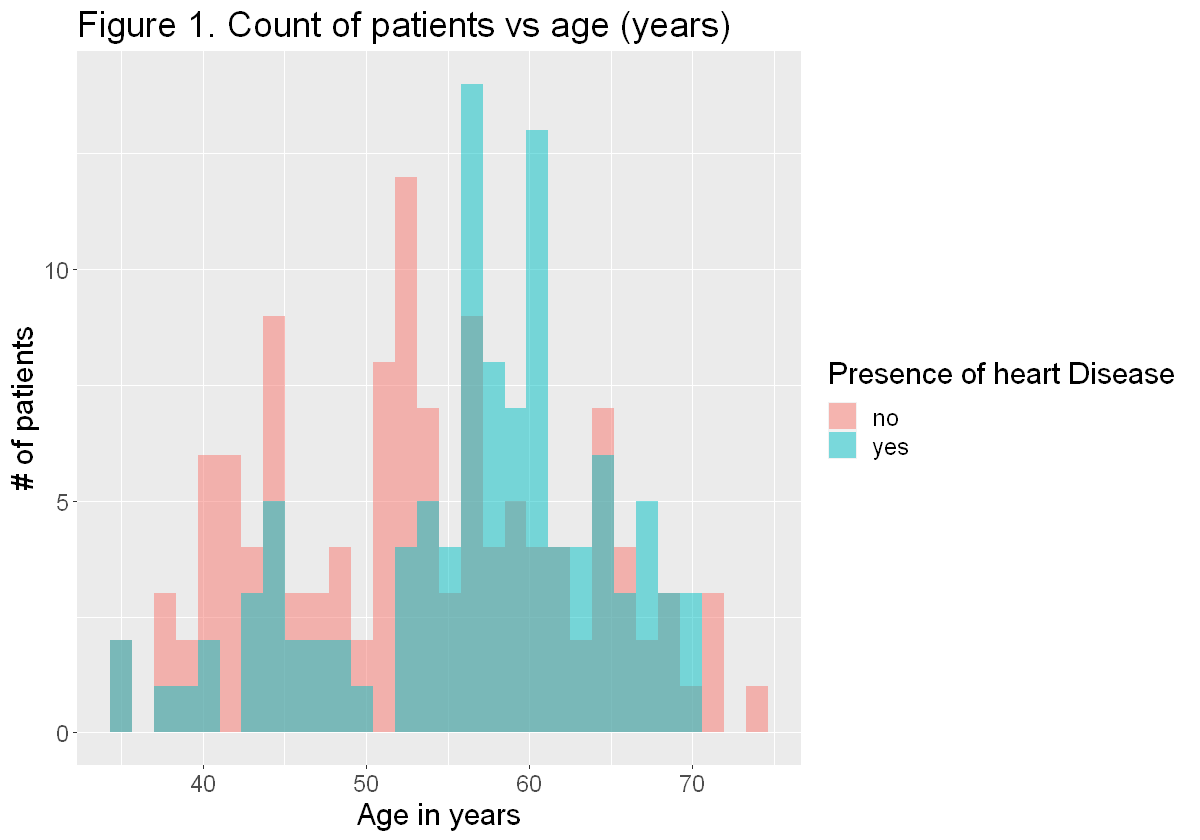

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


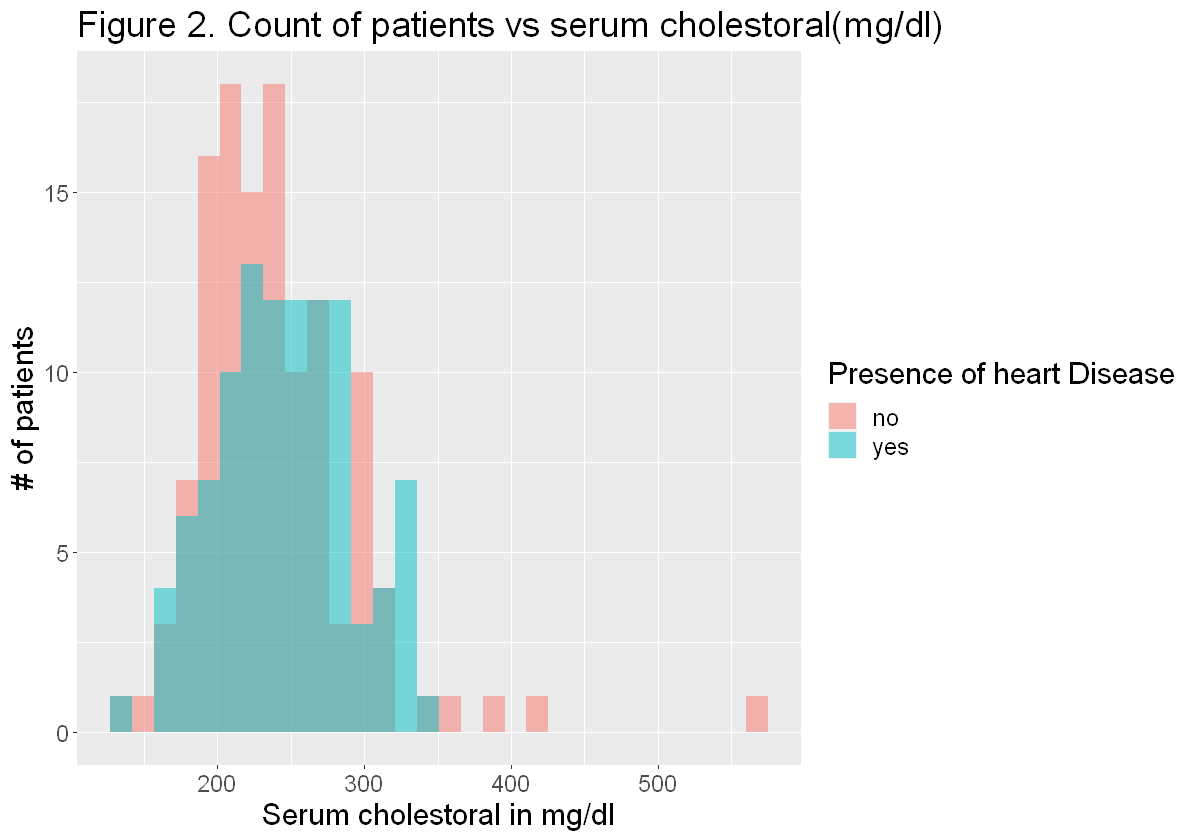

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


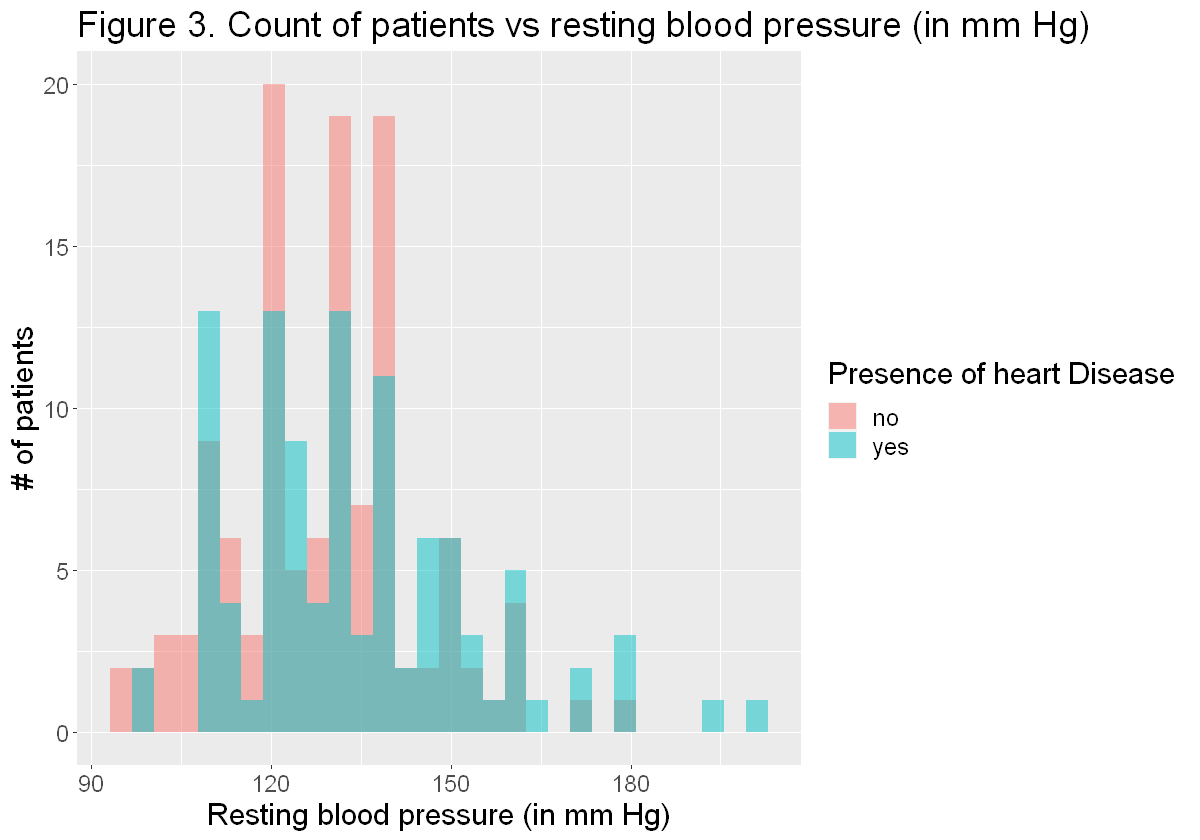

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


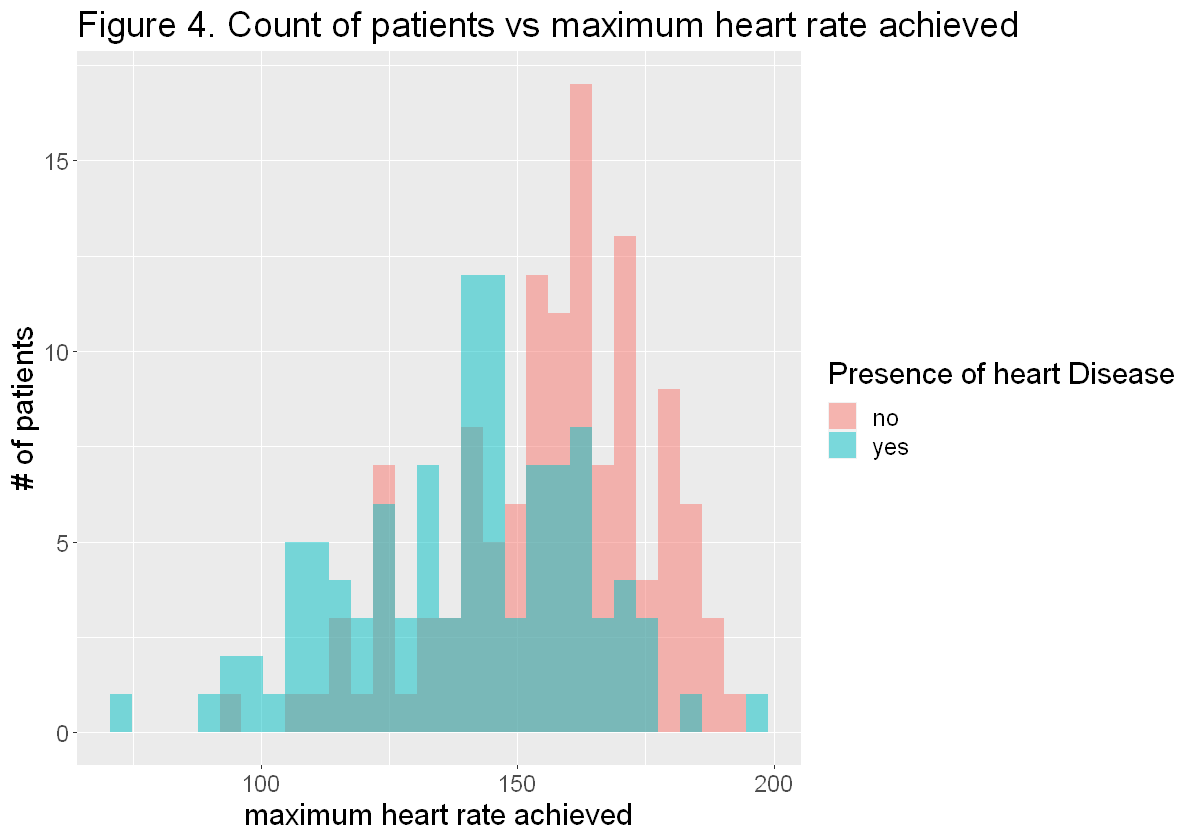

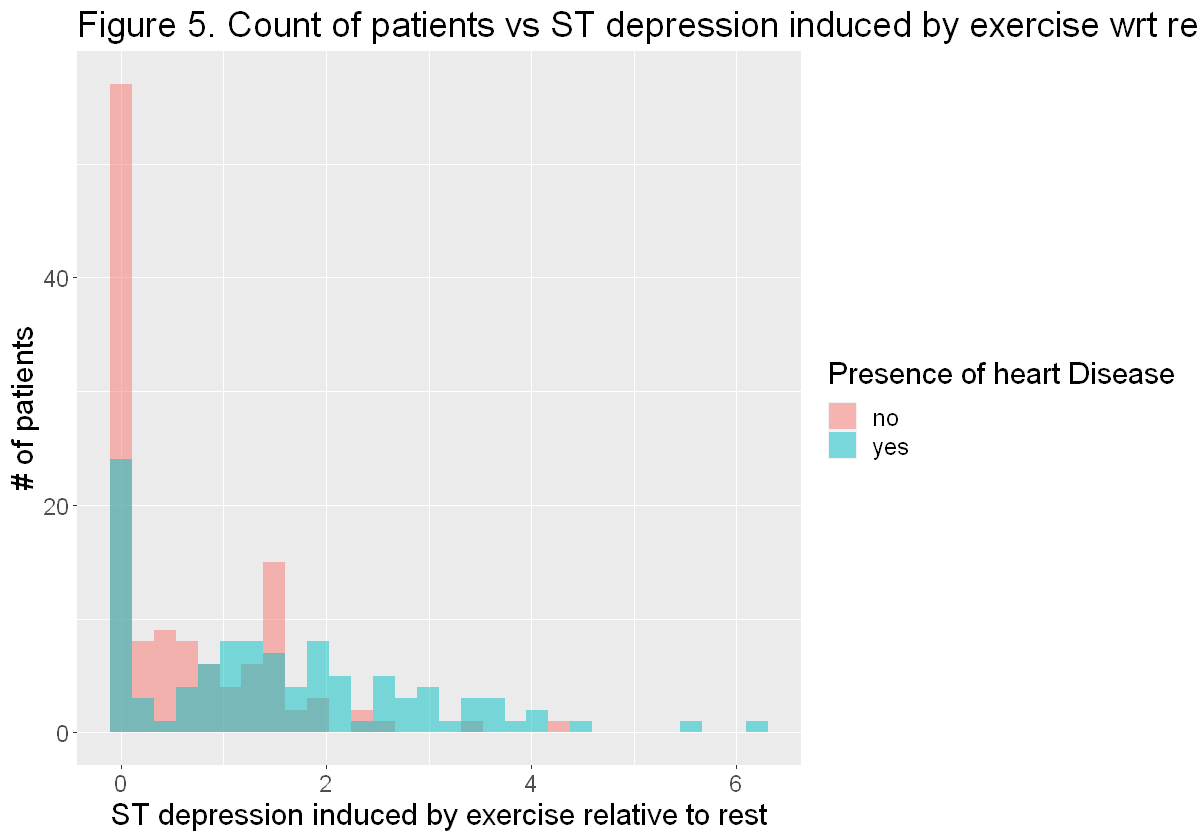

In [6]:
options(repr.plot.width = 10, repr.plot.height = 7)

# Presence/absence based on age
heart_disease_data_train_age_plot <- ggplot(heart_disease_data_train, aes(x = age)) +
                                    geom_histogram(aes(fill = presence), alpha = 0.5, position="identity") +
                                    labs(x = "Age in years", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Figure 1. Count of patients vs age (years)")
heart_disease_data_train_age_plot

# Presence/absence based on cholestrol
heart_disease_data_train_chol_plot <- ggplot(heart_disease_data_train, aes(x = chol)) +
                                    geom_histogram(aes(fill = presence), alpha = 0.5, position="identity") +
                                    labs(x = "Serum cholestoral in mg/dl", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Figure 2. Count of patients vs serum cholestoral(mg/dl)")
heart_disease_data_train_chol_plot


# Presence/absence based on resting blood pressure
heart_disease_data_train_trestbps_plot <- ggplot(heart_disease_data_train, aes(x = trestbps)) +
                                    geom_histogram(aes(fill = presence), alpha = 0.5, position="identity") +
                                    labs(x = "Resting blood pressure (in mm Hg)", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Figure 3. Count of patients vs resting blood pressure (in mm Hg)")
heart_disease_data_train_trestbps_plot

# Presence/absence based on maximum heart rate achieved
heart_disease_data_train_thalach_plot <- ggplot(heart_disease_data_train, aes(x = thalach)) +
                                    geom_histogram(aes(fill = presence), alpha = 0.5, position="identity") +
                                    labs(x = "maximum heart rate achieved", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Figure 4. Count of patients vs maximum heart rate achieved")
heart_disease_data_train_thalach_plot

# Presence/absence based on ST depression induced by exercise relative to rest
heart_disease_data_train_oldpeak_plot <- ggplot(heart_disease_data_train, aes(x = oldpeak)) +
                                    geom_histogram(aes(fill = presence), alpha = 0.5, position="identity") +
                                    labs(x = "ST depression induced by exercise relative to rest", y = "# of patients", fill = "Presence of heart Disease") +
                                    theme(text = element_text(size = 18)) +
                                    ggtitle("Figure 5. Count of patients vs ST depression induced by exercise wrt rest")
heart_disease_data_train_oldpeak_plot

### 2.5 Scatterplot of two variables at a time (EDA)

Here, will we do some EDA, where for all the 5 variables - `age`, `chol`, `oldpeak`, `thalach`, `trestbps`, we will plot scatterplots for a combination if 2 variables at a time. Hence, we will plot 10 scatterplots. 

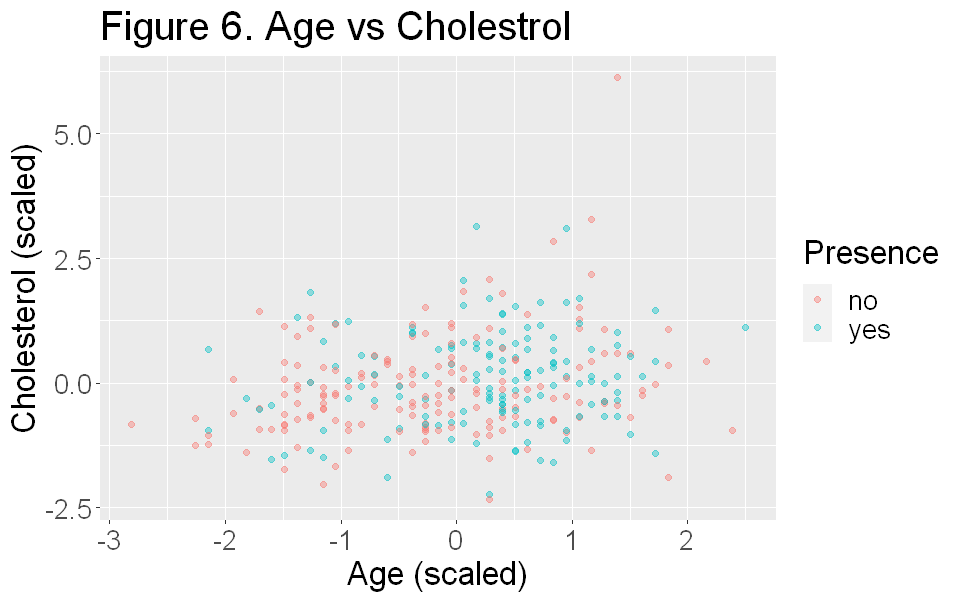

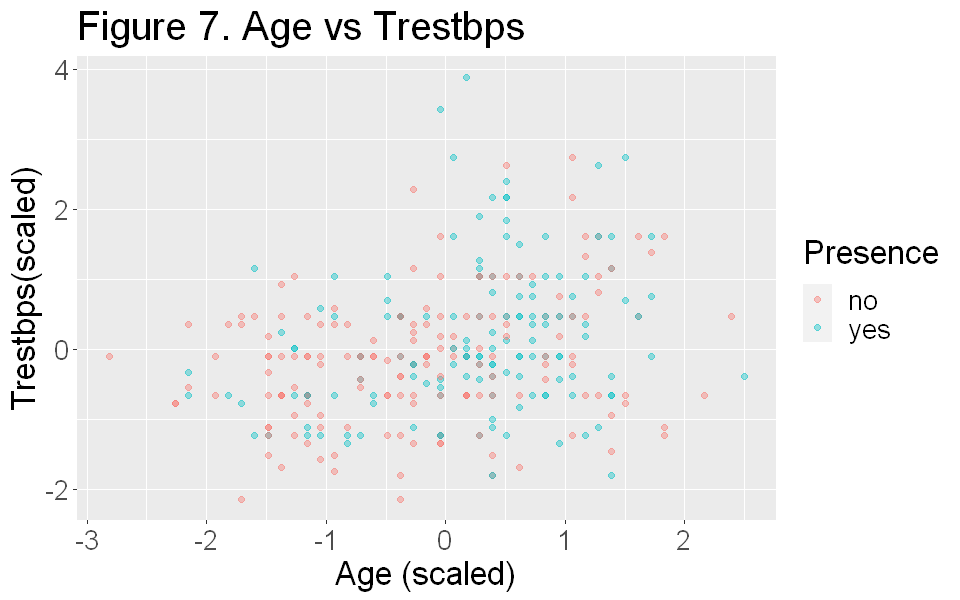

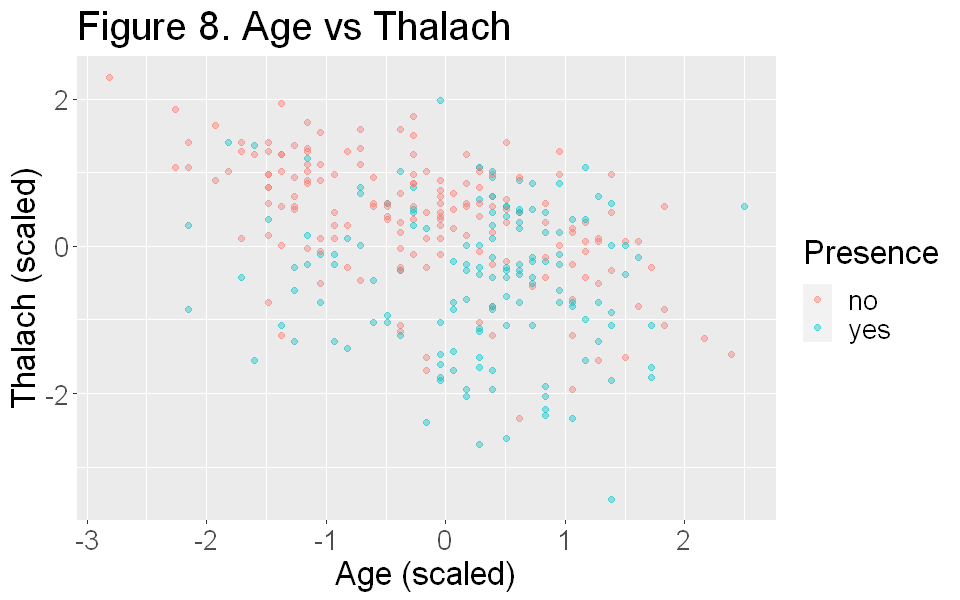

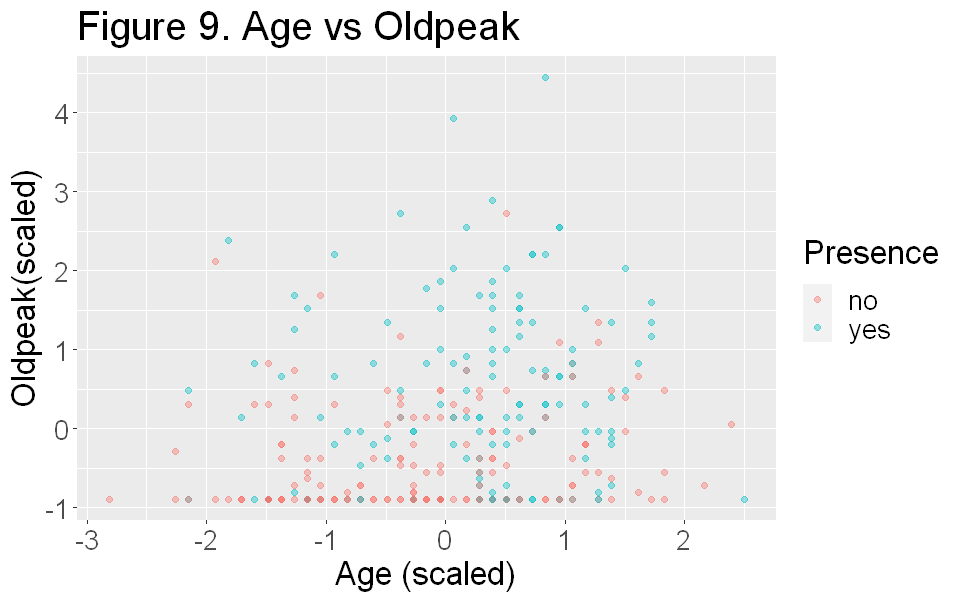

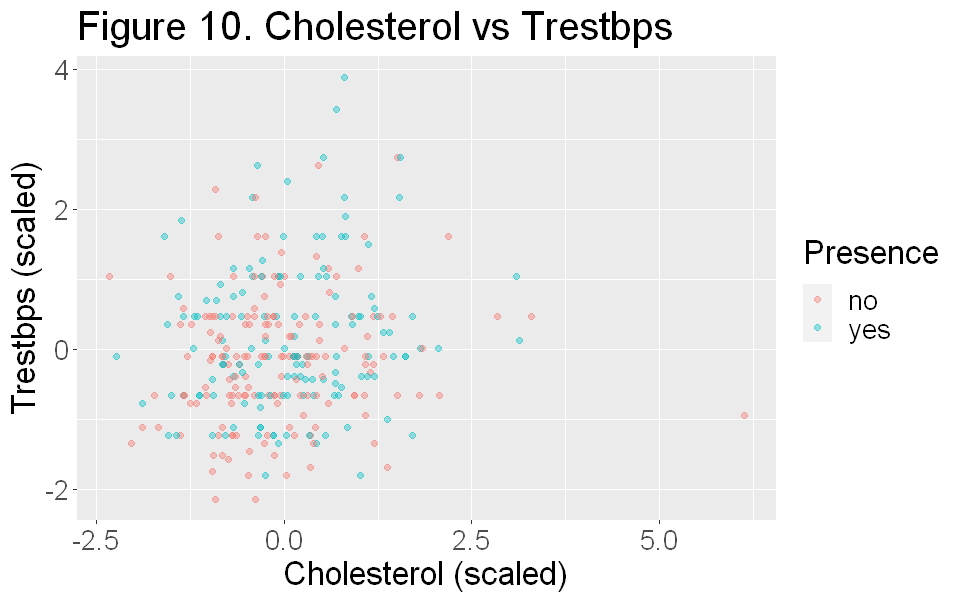

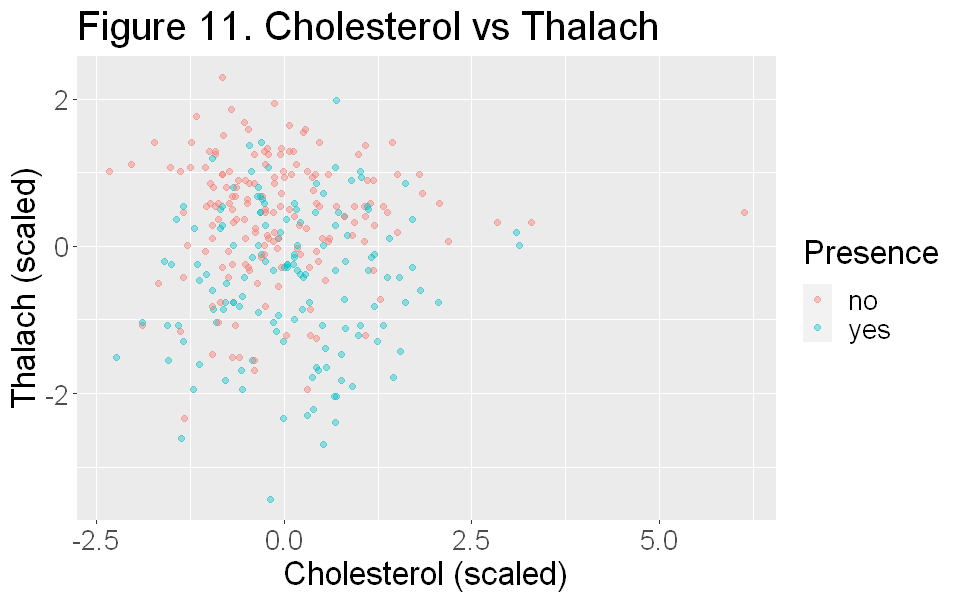

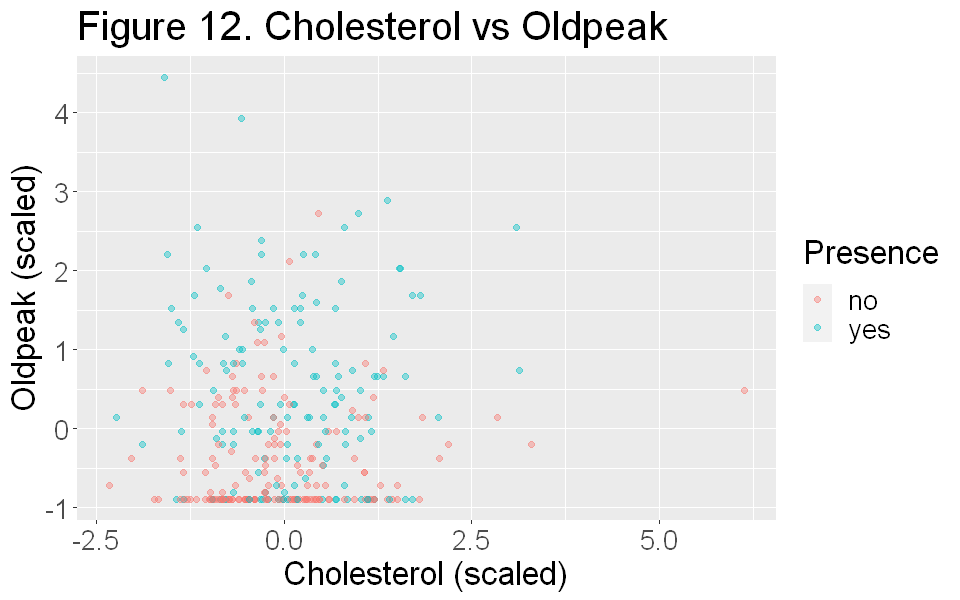

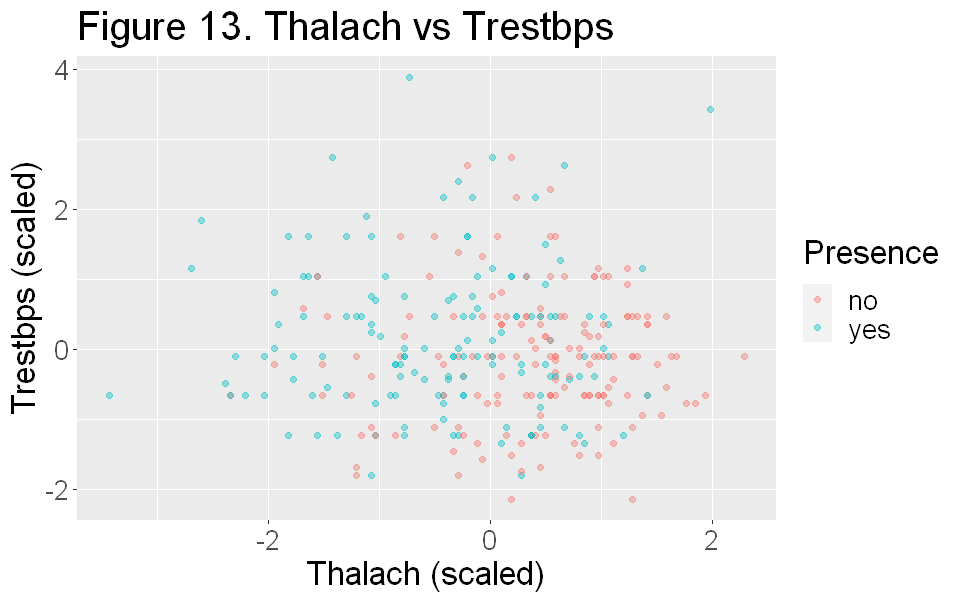

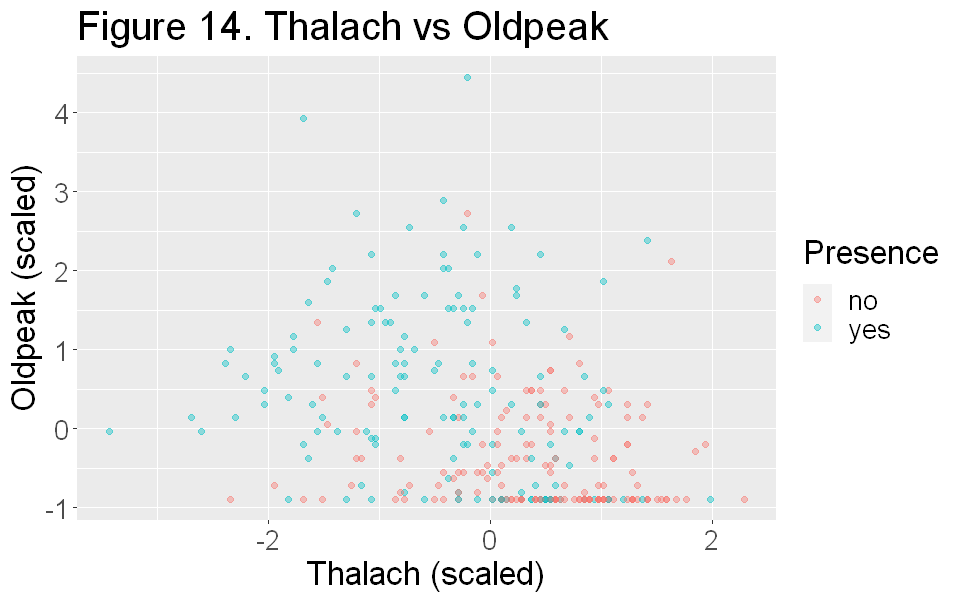

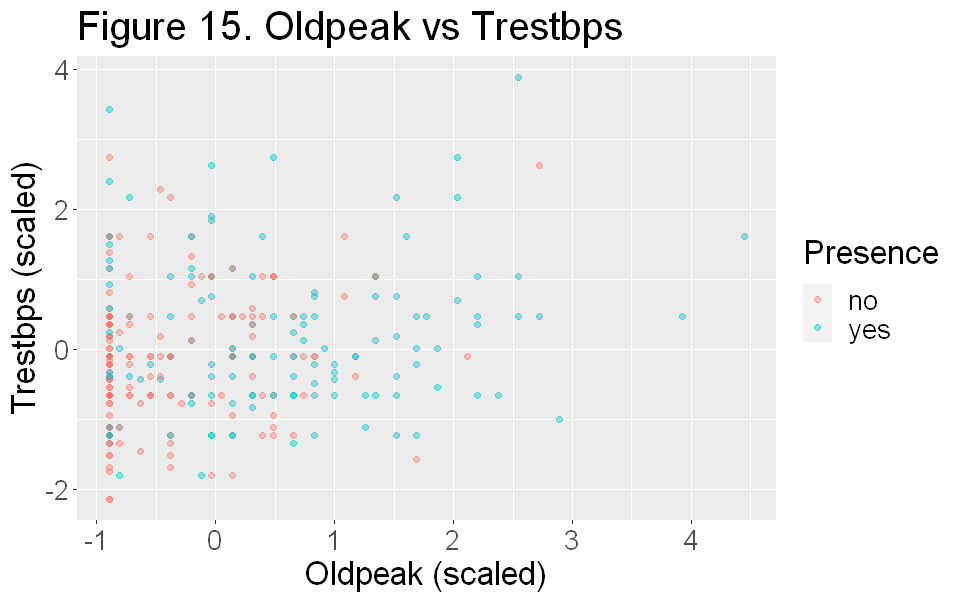

In [7]:
options(repr.plot.width = 8, repr.plot.height = 5)

# scale the variables 
heart_disease_data_scaled <- heart_disease_data %>%
  mutate(age = scale(age), chol = scale(chol), trestbps = scale(trestbps), thalach = scale(thalach), oldpeak = scale(oldpeak))

# 5 variables, 2 each time => 10 scatterplots 

# Age vs Chol
age_chol <- heart_disease_data_scaled %>%
  ggplot(aes(x = age, y = chol, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Age (scaled)", 
       y = "Cholesterol (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20)) +
  ggtitle("Figure 6. Age vs Cholestrol")
age_chol

# Age vs Trestbps
age_trestbps <- heart_disease_data_scaled %>%
  ggplot(aes(x = age, y = trestbps, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Age (scaled)", 
       y = "Trestbps(scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20)) +
  ggtitle("Figure 7. Age vs Trestbps")
age_trestbps

# Age vs Thalach
age_thalach <- heart_disease_data_scaled %>%
  ggplot(aes(x = age, y = thalach, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Age (scaled)", 
       y = "Thalach (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20)) +
  ggtitle("Figure 8. Age vs Thalach") 
age_thalach

# Age vs Oldpeak
age_oldpeak <- heart_disease_data_scaled %>%
  ggplot(aes(x = age, y = oldpeak, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Age (scaled)", 
       y = "Oldpeak(scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 9. Age vs Oldpeak")
age_oldpeak

# Chol vs Trestbps
chol_trestbps <- heart_disease_data_scaled %>%
  ggplot(aes(x = chol, y = trestbps, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Cholesterol (scaled)", 
       y = "Trestbps (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 10. Cholesterol vs Trestbps")
chol_trestbps

# Chol vs Thalach
chol_thalach <- heart_disease_data_scaled %>%
  ggplot(aes(x = chol, y = thalach, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Cholesterol (scaled)", 
       y = "Thalach (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 11. Cholesterol vs Thalach")
chol_thalach

# Chol vs Oldpeak
chol_oldpeak <- heart_disease_data_scaled %>%
  ggplot(aes(x = chol, y = oldpeak, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Cholesterol (scaled)", 
       y = "Oldpeak (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 12. Cholesterol vs Oldpeak")
chol_oldpeak

# Thalach vs Trestbps
thalach_trestbps <- heart_disease_data_scaled %>%
  ggplot(aes(x = thalach, y = trestbps, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Thalach (scaled)", 
       y = "Trestbps (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 13. Thalach vs Trestbps")
thalach_trestbps

# Thalach vs Oldpeak
thalach_oldpeak <- heart_disease_data_scaled %>%
  ggplot(aes(x = thalach, y = oldpeak, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Thalach (scaled)", 
       y = "Oldpeak (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 14. Thalach vs Oldpeak")
thalach_oldpeak

# Oldpeak vs Trestbps
oldpeak_trestbps <- heart_disease_data_scaled %>%
  ggplot(aes(x = oldpeak, y = trestbps, color = presence)) +
  geom_point(alpha = 0.4) +
  labs(x = "Oldpeak (scaled)", 
       y = "Trestbps (scaled)",
       color = "Presence") +
       theme(text = element_text(size = 20))  +
  ggtitle("Figure 15. Oldpeak vs Trestbps")
oldpeak_trestbps


We can see that Age vs Thalach, Age vs Oldpeak, Oldpeak vs Thalach are still the best variable sthat can still successfully distinguish between presence and absence of heart disease without getting too muddled.

### 2.6 EDA (using ggpairs) 

We will examine the relationships between our 5 predictor attributes - `age`, `chol`, `oldpeak`, `thalach`, `trestbps` and the predicted attribute `presence` to select the most relevant attributes for our classification model.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


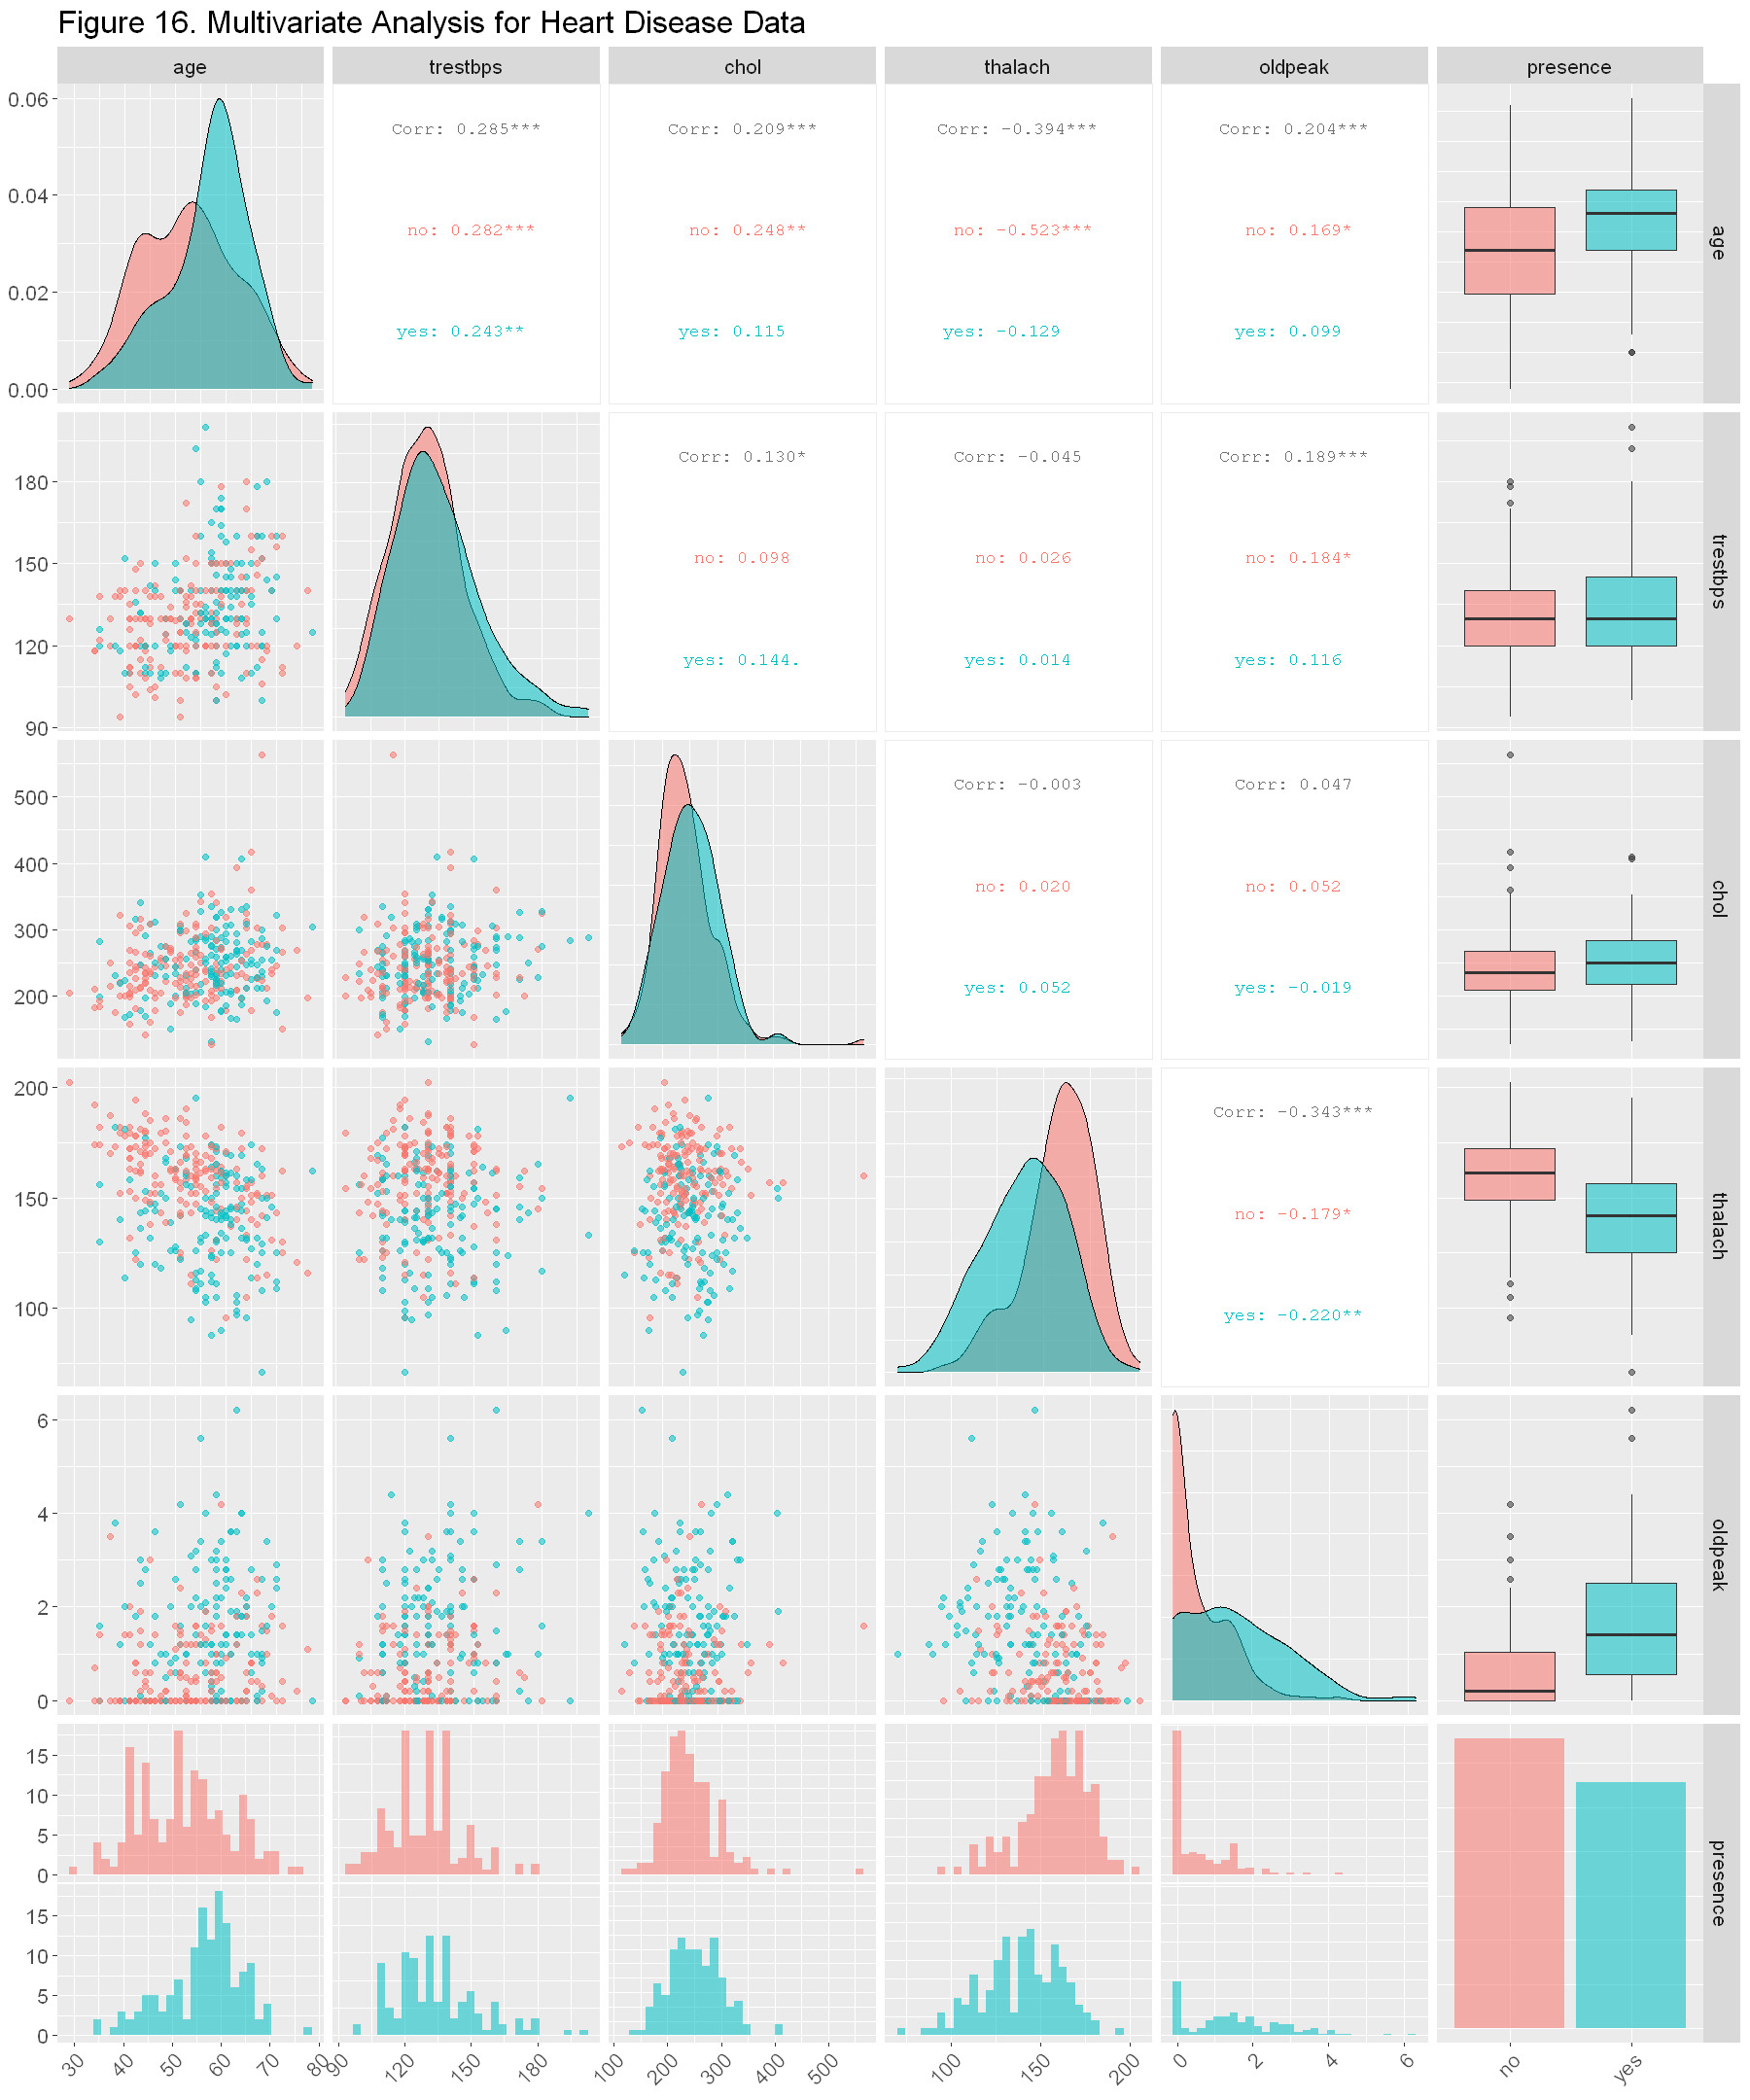

In [8]:
options(repr.plot.width = 15, repr.plot.height = 18)

#scatterplot matrix (ggpairs) with all categorical variables
multivariate_plot <- heart_disease_data %>%
    ggpairs(mapping = ggplot2::aes(colour = presence, alpha = 0.4)) +  
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    theme(text = element_text(size = 16)) +
    ggtitle("Figure 16. Multivariate Analysis for Heart Disease Data")

multivariate_plot 

## 3. Classification

Many physiological attributes have been shown through studies and reports by the CDC and WHO to have strong links to heart disease. After filtering out categorical variables and examining the data using `ggpairs`, we have chosen the three most relevant out of the five numerical values in our dataset to analyze: `thalach` (maximum heart rate achieved), `oldpeak` (ST depression induced by exercise relative to rest), and `age` (age in years). Using ggpairs, we can see that `oldpeak`, `thalach`, and `age` work better in helping distinguish the classification between the presence and absence of heart disease as their Using our chosen variables, we will construct and test a classifier using the KNN classification model and choose an appropriate k using cross-validation.

### 3.1 Creating the model and recipe

In [9]:
#Creating model and recipe

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")


hd_recipe <- recipe(presence ~ age + oldpeak + thalach, data = heart_disease_data_train) %>%
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

hd_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

### 3.2 Performing cross-validation and determining which k to use

Finding the best K for KNN by varying K from 1 to 125 in increments of 2 and running a 5-fold cross validation. We will then filter the maximum accuracy neighbour and see if it is the right K to choose using the plot below.

In [10]:
set.seed(999)
hd_vfold <- vfold_cv(heart_disease_data_train, v = 5, strata = presence)

k_vals <- tibble(neighbors = seq(from = 1, to = 125, by = 2))

# workflow 
knn_results <- workflow() %>%
                 add_recipe(hd_recipe) %>%
                 add_model(knn_spec) %>%
                 tune_grid(resamples = hd_vfold, grid = k_vals) %>%
                 collect_metrics()

## accuracies for all the neighbours of k =1 to k = 125 in increments of 2
accuracies <- knn_results %>%
                 filter(.metric == "accuracy")
accuracies

## maximum accuracy 
max_accuracy <- accuracies %>%
                    filter(mean == max(mean))
max_accuracy

Warning message:
"package 'rlang' was built under R version 3.6.3"
Attaching package: 'rlang'

The following objects are masked from 'package:purrr':

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice

Warning message:
"package 'vctrs' was built under R version 3.6.3"
Attaching package: 'vctrs'

The following object is masked from 'package:dplyr':

    data_frame

The following object is masked from 'package:tibble':

    data_frame

Warning message:
"package 'kknn' was built under R version 3.6.3"

neighbors,.metric,.estimator,mean,n,std_err,.config
1,accuracy,binary,0.6558630,5,0.04793530,Preprocessor1_Model01
3,accuracy,binary,0.6333377,5,0.04309644,Preprocessor1_Model02
5,accuracy,binary,0.6331401,5,0.04483357,Preprocessor1_Model03
7,accuracy,binary,0.6599166,5,0.03090470,Preprocessor1_Model04
9,accuracy,binary,0.6555687,5,0.02913862,Preprocessor1_Model05
11,accuracy,binary,0.6910321,5,0.03422865,Preprocessor1_Model06
13,accuracy,binary,0.7037857,5,0.03877001,Preprocessor1_Model07
15,accuracy,binary,0.7126746,5,0.03770146,Preprocessor1_Model08
17,accuracy,binary,0.6996355,5,0.03118728,Preprocessor1_Model09
19,accuracy,binary,0.7042732,5,0.02998118,Preprocessor1_Model10


neighbors,.metric,.estimator,mean,n,std_err,.config
59,accuracy,binary,0.7219631,5,0.03169323,Preprocessor1_Model30


### 3.3 Plot of K vs Accuracy to choose the most optimal K value 

As we can see from above we get the maximum accuracy at k = 59. We will examine the plot below to determine the most optimal K.

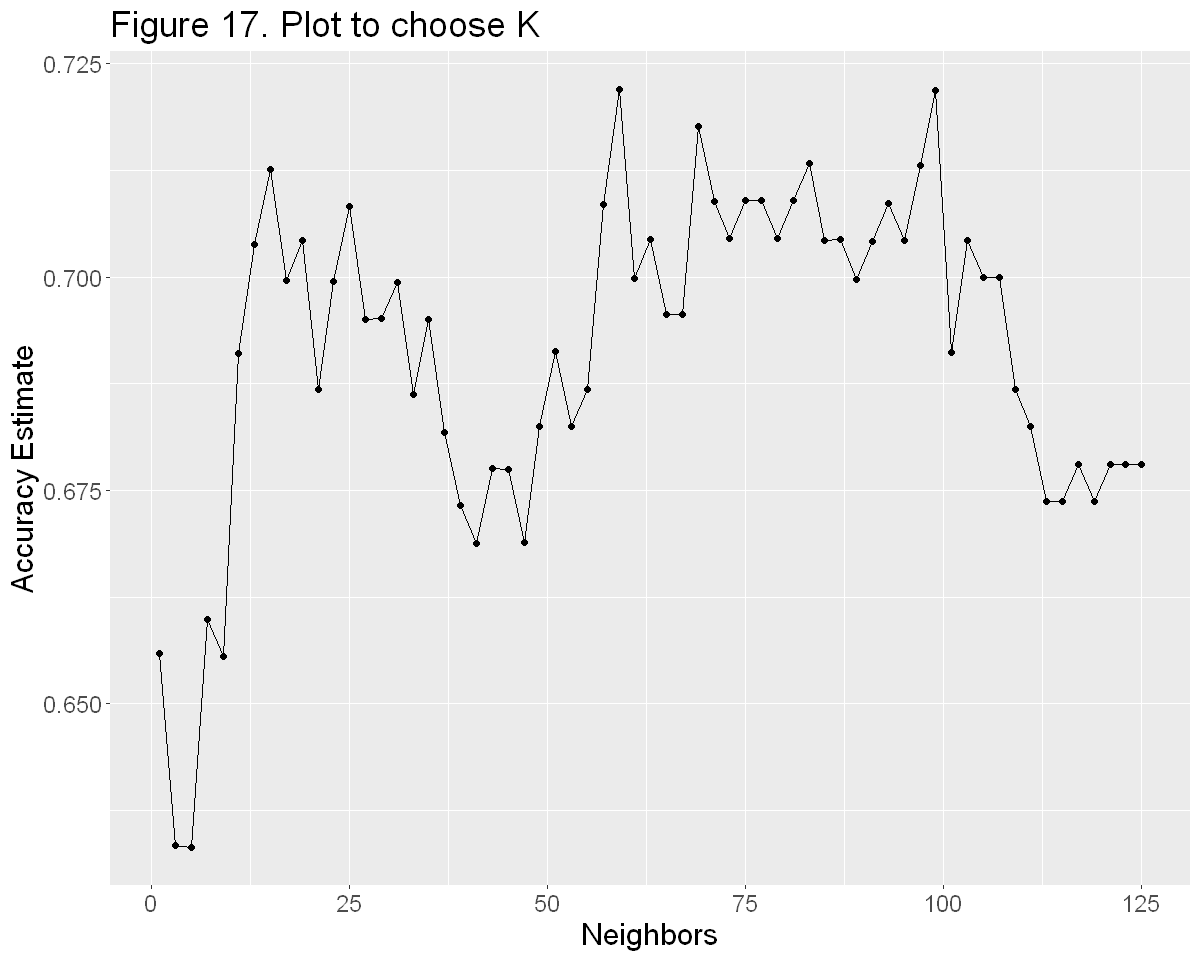

In [11]:
options(repr.plot.width = 10, repr.plot.height = 8)

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 18)) +
                  ggtitle("Figure 17. Plot to choose K")
cross_val_plot

From the plot above, we see that the plot seems to oscillate a lot as the number of neighbors increases. This is likely because the dataset is small (only ~300 rows of data) which is why the model is trying to gather as much information possible by having more neighbors. However we notice that k = 59 is the optimal choice of K since it gives us the maximum accuracy and is also a reasonably right number of neighbors to avoid underfitting or overfitting. Cost of training will not be very expensive either since k is not too large but optimal.

In [12]:
# spec with num of neighbors = 21
knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 59) %>%
  set_engine("kknn") %>%
  set_mode("classification")

hd_fit <- workflow () %>%
                  add_recipe(hd_recipe) %>%
                  add_model(knn_spec2) %>% 
                  fit(data = heart_disease_data_train)
hd_fit

== Workflow [trained] ==========================================================
Preprocessor: Recipe
Model: nearest_neighbor()

-- Preprocessor ----------------------------------------------------------------
2 Recipe Steps

* step_scale()
* step_center()

-- Model -----------------------------------------------------------------------

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(59,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3215859
Best kernel: rectangular
Best k: 59

In [13]:
hd_test_predictions <- predict(hd_fit, heart_disease_data_test) %>%
  bind_cols(heart_disease_data_test)

hd_metrics <- hd_test_predictions %>% 
                metrics(truth = presence, estimate = .pred_class) %>%
                filter(.metric == "accuracy")

hd_conf_mat <- hd_test_predictions %>%
                        conf_mat(truth = presence, estimate = .pred_class) 

hd_metrics
hd_conf_mat

.metric,.estimator,.estimate
accuracy,binary,0.75


          Truth
Prediction no yes
       no  36  14
       yes  5  21

### 3.4 Comparing presence to predictions

In the following graphs, we look at the actual presence values on the left plots, and the predicted presence values on the right plots. These are scatterplots between 2 attributes at a time from the 3 attributes - age, thalach, oldpeak, we used in our classification model.

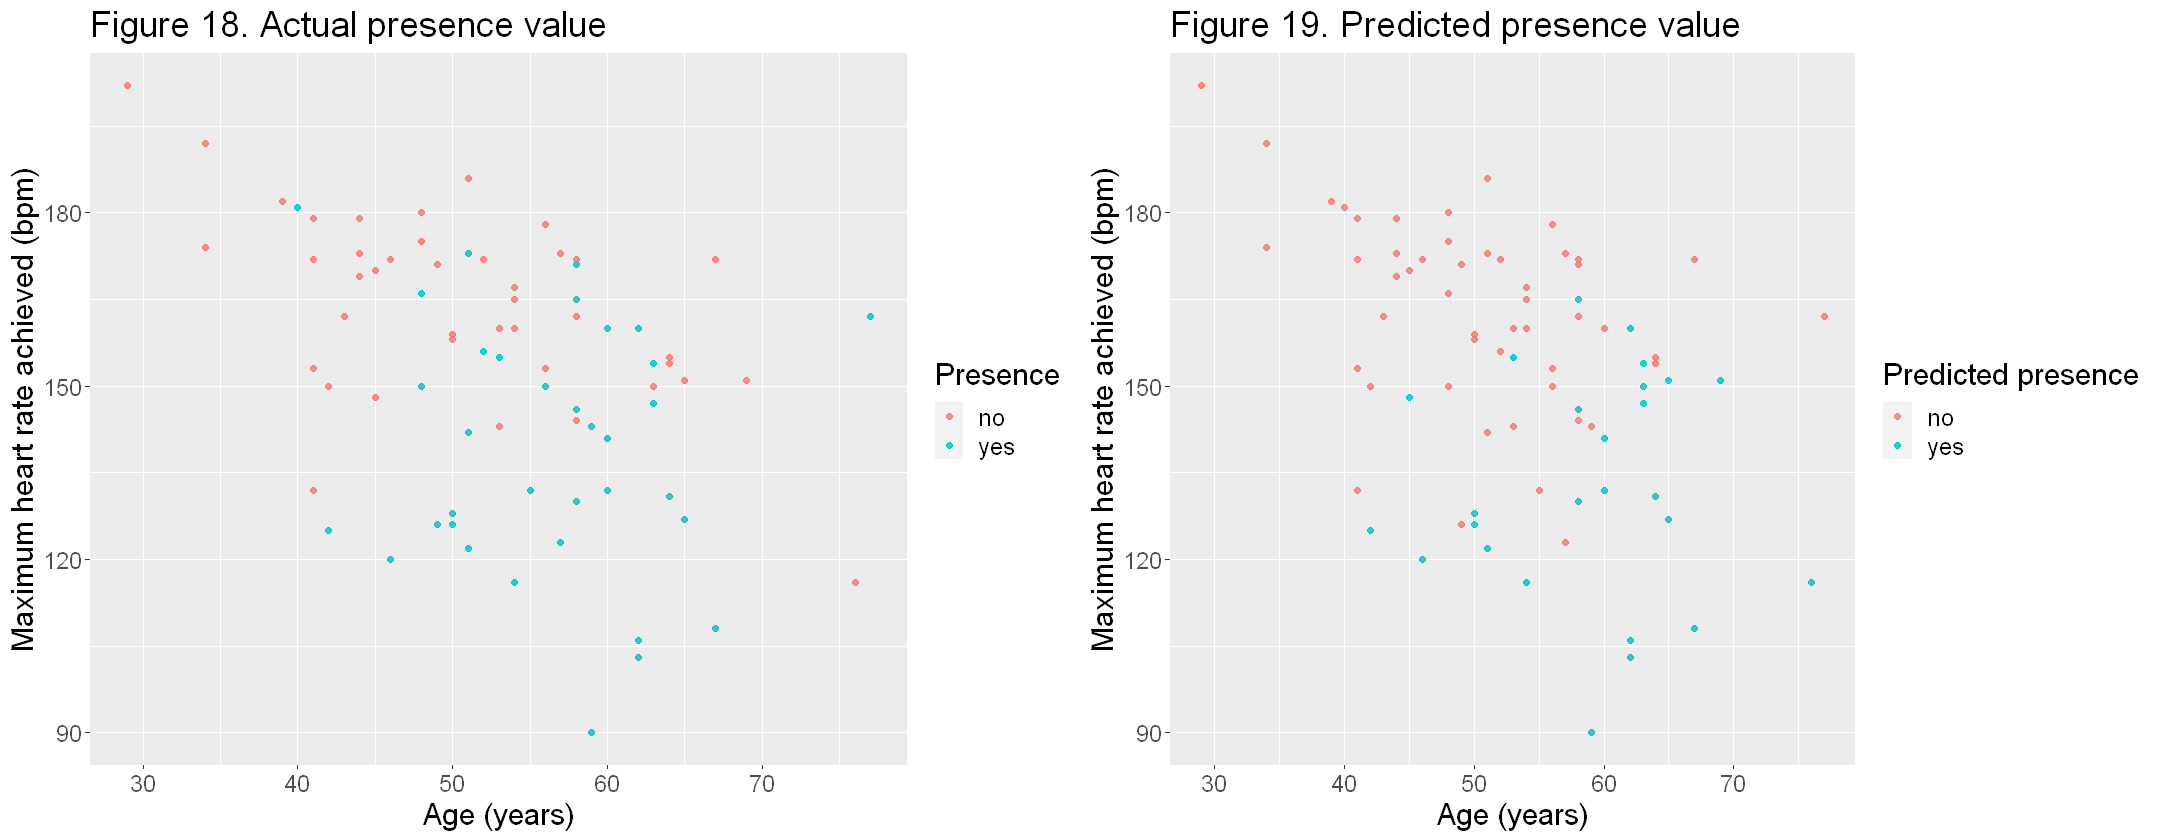

In [14]:
options(repr.plot.width = 18, repr.plot.height = 7)

age_thalach_plot <- ggplot(hd_test_predictions, aes(x = age, y = thalach, color = presence)) +
            geom_point(alpha = 0.8) +
            labs(x = "Age (years)", y = "Maximum heart rate achieved (bpm)", colour = "Presence") + 
            theme(text = element_text(size = 18)) +
            ggtitle("Figure 18. Actual presence value")


age_thalach_preds <- ggplot(hd_test_predictions, aes(x = age, y = thalach, color = .pred_class)) +
            geom_point(alpha = 0.8) +
            labs(x = "Age (years)", y = "Maximum heart rate achieved (bpm)", colour = "Predicted presence") + 
            theme(text = element_text(size = 18)) +
            ggtitle("Figure 19. Predicted presence value")

plot_grid(age_thalach_plot, age_thalach_preds)

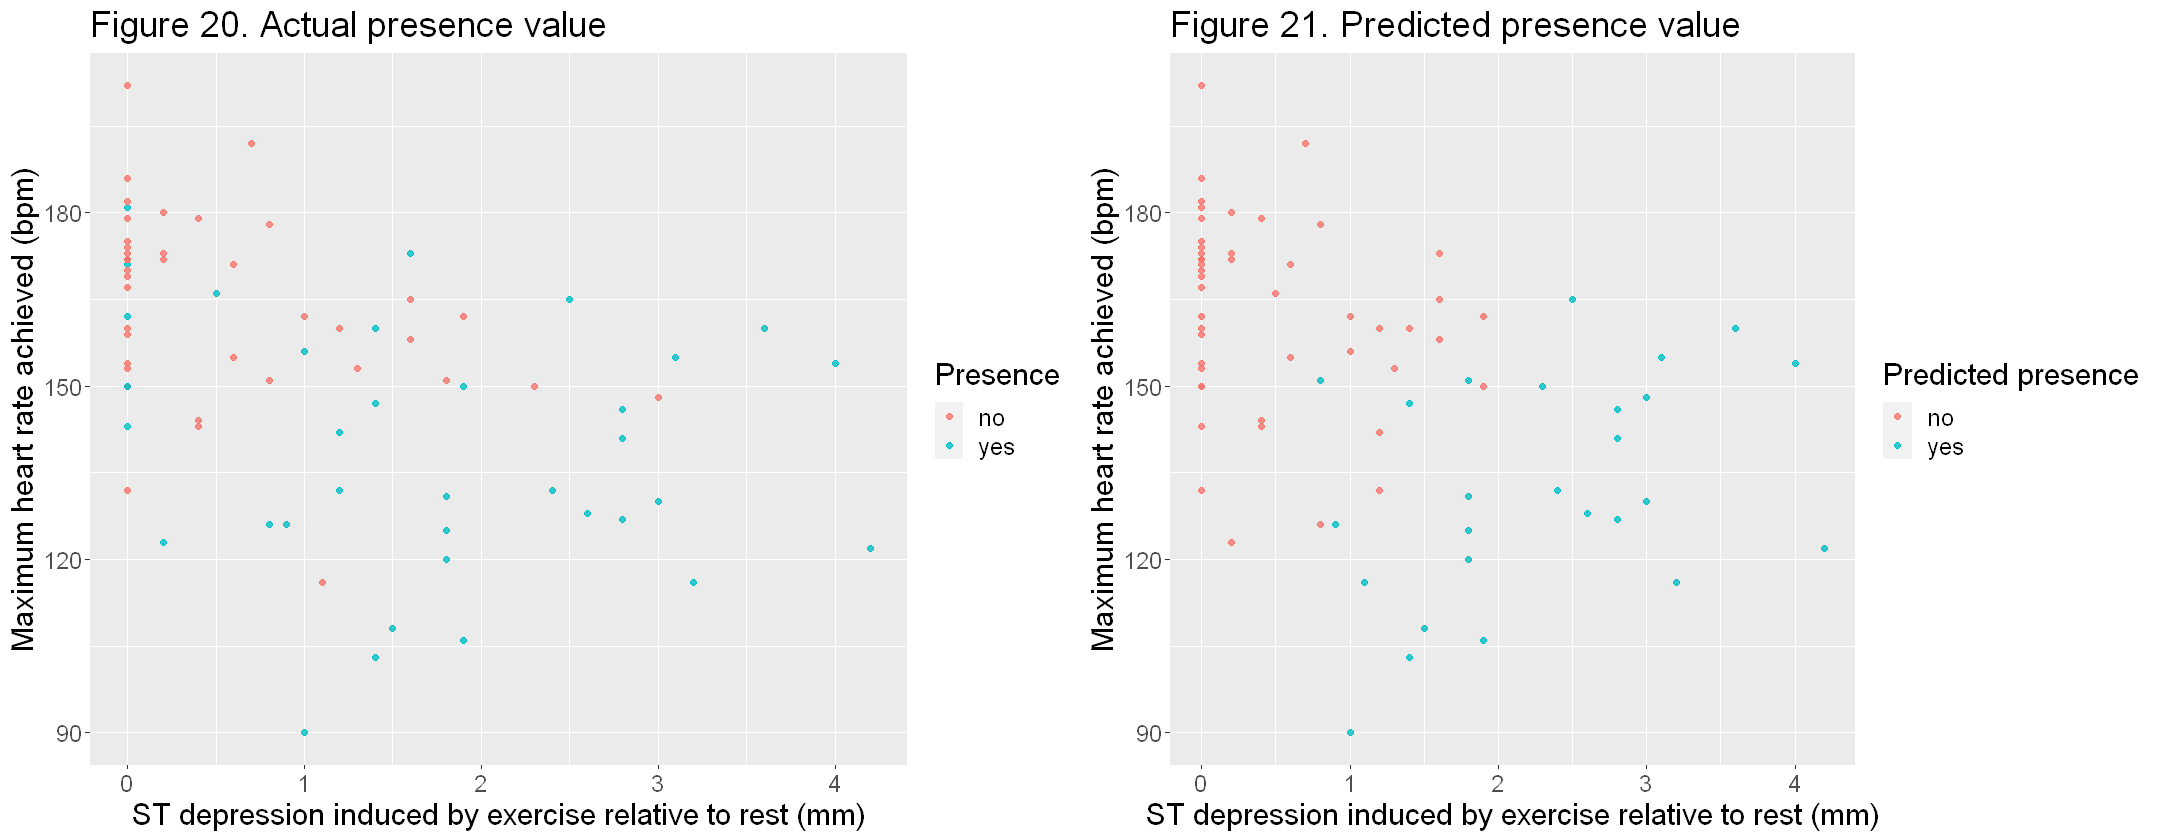

In [15]:
options(repr.plot.width = 18, repr.plot.height = 7)

oldpeak_thalach_plot <- ggplot(hd_test_predictions, aes(x = oldpeak, y = thalach, color = presence)) +
            geom_point(alpha = 0.8) +
            labs(x = "ST depression induced by exercise relative to rest (mm)", y = "Maximum heart rate achieved (bpm)", colour = "Presence") + 
            theme(text = element_text(size = 18)) +
            ggtitle("Figure 20. Actual presence value")

oldpeak_thalach_preds <- ggplot(hd_test_predictions, aes(x = oldpeak, y = thalach, color = .pred_class)) +
            geom_point(alpha = 0.8) +
            labs(x = "ST depression induced by exercise relative to rest (mm)", y = "Maximum heart rate achieved (bpm)", colour = "Predicted presence") + 
            theme(text = element_text(size = 18)) +
            ggtitle("Figure 21. Predicted presence value")
plot_grid(oldpeak_thalach_plot, oldpeak_thalach_preds)

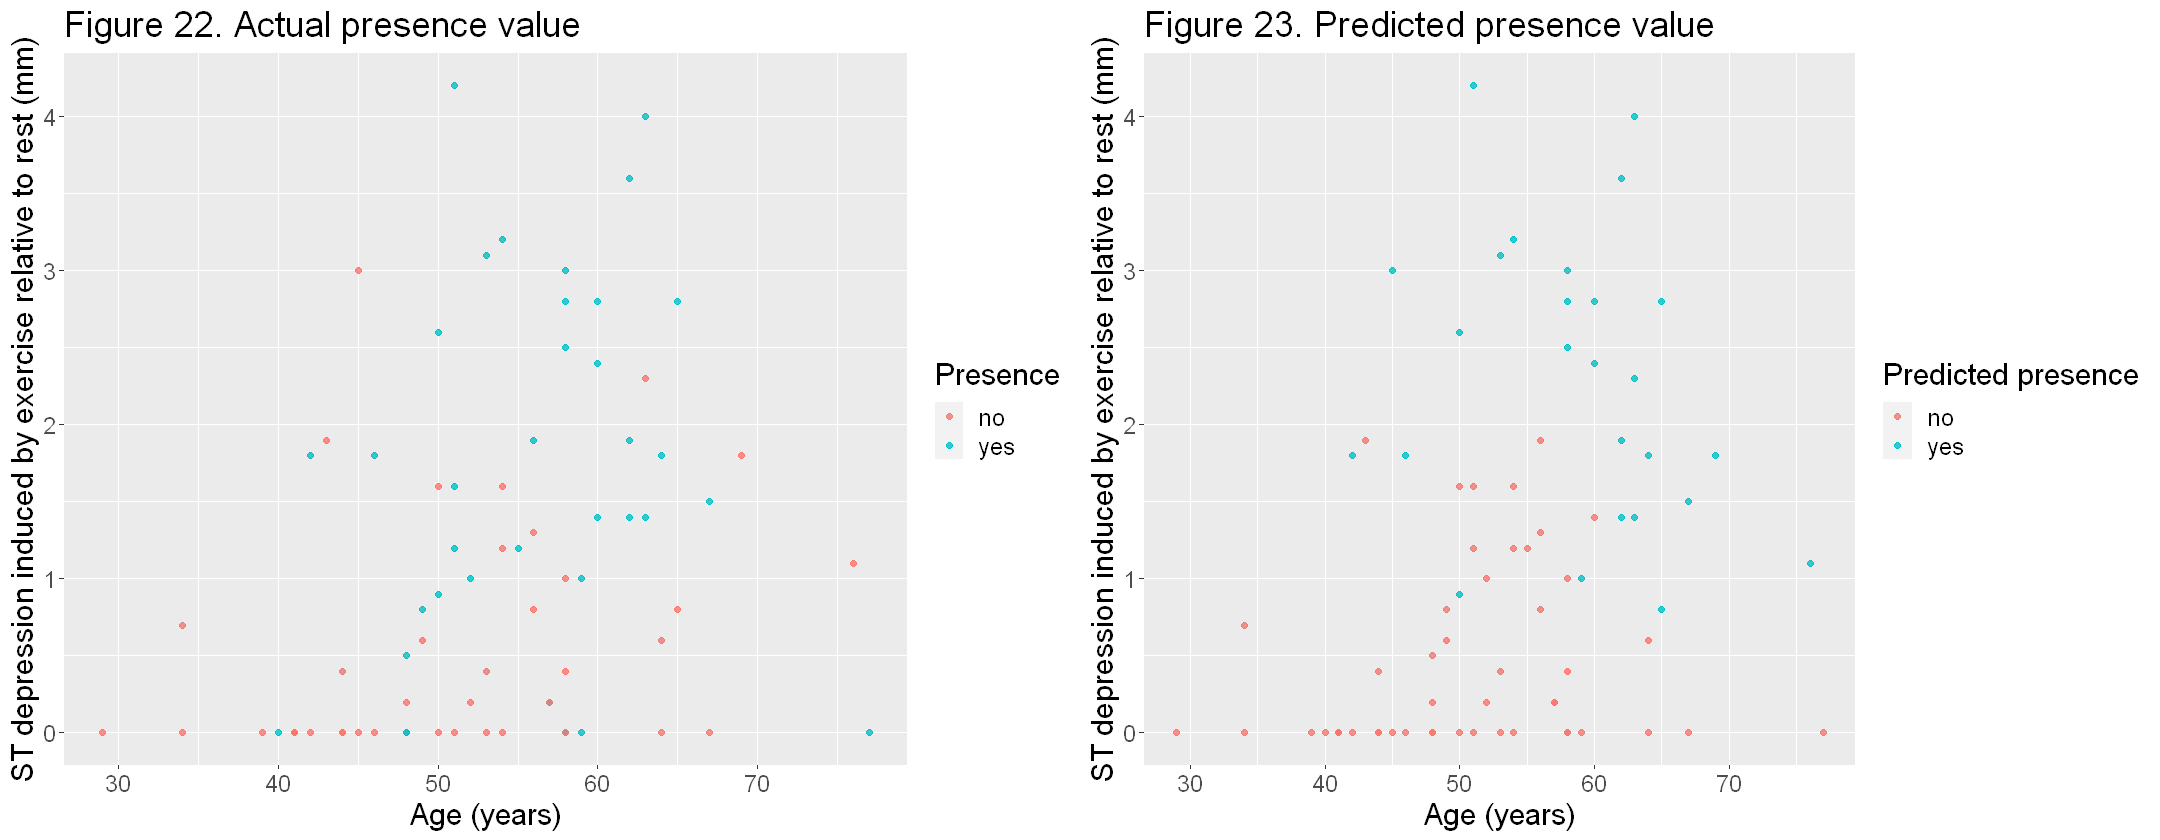

In [16]:

options(repr.plot.width = 18, repr.plot.height = 7)

age_oldpeak_plot <- ggplot(hd_test_predictions, aes(x = age, y = oldpeak, color = presence)) +
            geom_point(alpha = 0.8) +
            labs(x = "Age (years)", y = "ST depression induced by exercise relative to rest (mm)", colour = "Presence") + 
            theme(text = element_text(size = 18)) +
            ggtitle("Figure 22. Actual presence value")

age_oldpeak_preds <- ggplot(hd_test_predictions, aes(x = age, y = oldpeak, color = .pred_class)) +
            geom_point(alpha = 0.8) +
            labs(x = "Age (years)", y = "ST depression induced by exercise relative to rest (mm)", colour = "Predicted presence") + 
            theme(text = element_text(size = 18)) +
            ggtitle("Figure 23. Predicted presence value")

plot_grid(age_oldpeak_plot, age_oldpeak_preds)

## 4. Discussion

### 4.1 Findings
Our classification model with 3 predictors (age, thalach, oldpeak) can predict with about 75% accuracy whether heart disease will be present or absent in a (new, unseen) patient. 

### 4.2 Expectations 
We had expected to be able to find an even higher accuracy model as this model will be used to classify the presence or absence of heart disease in a patient. For such a domain we would like to have an insanely high accuracy to avoid false negatives where someone is classified as having absence of heart disease when they could have it and would have needed treatment. 

### 4.3 Possible Impacts
- Using our model, patients can be classified as high or low risk for heart disease using their age (`age`), maximum heart rate achieved (`thalach`), and ST depression induced by exercise with rest (`oldpeak`).
- Early diagnosis of heart disease based on this classification can help save more lives by allowing patients to make lifestyle adjustments or seek medical assistance sooner.


### 4.4 Future Questions
- Are there other factors not included in this dataset which could be important in predicting presence of heart disease?
- If more factors are considered (outside of what this dataset contains), would it improve accuracy of the model?


## 5. References

### Study investigating the link between ST depression in ECG and heart disease
Diderholm, E., Andrén, B., Frostfeldt, G., Genberg, M., Jernberg, T., Lagerqvist, B., Lindahl, B., & Wallentin, L., 2nd (2002). ST depression in ECG at entry indicates severe coronary lesions and large benefits of an early invasive treatment strategy in unstable coronary artery disease; the FRISC II ECG substudy. The Fast Revascularisation during InStability in Coronary artery disease. European heart journal, 23(1), 41–49. https://doi.org/10.1053/euhj.2001.2694

### Study investigating the link between aging and heart disease
North, B. J., & Sinclair, D. A. (2012). The intersection between aging and cardiovascular disease. Circulation research, 110(8), 1097–1108. https://doi.org/10.1161/CIRCRESAHA.111.246876

### Data repository
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

### Data set
Janosi, Andras, M.D., Steinbrunn, William, M.D., Pfisterer, Matthias, M.D., Detrano, Robert, M.D., Ph.D., Heart Disease Data Set. Hungarian Institute of Cardiology, Budapest. University Hospital, Zurich, Switzerland. University Hospital, Basel, Switzerland. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/heart+disease